# Colab データインストール

In [0]:
# 以下を実行すると、認証情報を取得するための許可を求められるので、許可してトークンを発行し、テキストボックスに貼り付ける。
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()

In [0]:
# Colabにおいてデータを読みこむ。グーグルドライブをマウントします。その為に必要なパッケージを取得しておく。
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse


In [4]:
# 以下実行により、今度は google-drive-ocamlfuse によるアクセスの許可を聞かれる。これも許可する。
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [5]:
# 今回は指定したフォルダのみマウントする
!cp -f ~/.gdfuse/default/config config
!sed -i -e "s/^root_folder=$/root_folder=1FwGdPnKlcYYRe1mZGE5Ci-PWlIY8k5J7/" config
# 上記が正常に終われば、ようやくマウントが可能となる。
!mkdir -p drive
!google-drive-ocamlfuse -config ./config -cc drive
!ls drive

Clearing cache...done
8_10-11  8_5-6			     Kaggle_0
8_12-13  8_7-8			     Santander_Value_Prediction_Challenge
8_14	 compare-deeplibs.ipynb      test.ipynb
8_15-16  dataマウントテンプレ.ipynb  week3-EDA
8_3-4	 dataset		     week4


In [1]:
# これ以降はターミナルと同様にディレクトリを扱える
ls

adc.json  config  datalab@  drive/  sample_data/


In [2]:
cd drive/dataset/Wholesale_customers/

/content/drive/dataset/Wholesale_customers


In [3]:
ls

url.txt  Wholesale customers data.csv


# 本編

## 問題提起

データはポルトガルのリスボンにある卸売業者（wholesale）が顧客から集めたものです。  
中身は各顧客が年間でミルクや食料品を何ユーロ購入しているかというデータになっています。  
卸売業者ですので、顧客は小売店やレストランです。

今回は教師なし学習として、データをクラスタリングしてその意味を見つけていくことを目指します。  

## 導入

【課題】教師なし学習とは何か記述せよ  
___
**教師あり学習との比較**  
正解のラベルが与えられていません。ですので、返ってくる結果に対して  
人間が意味を考える必要があります。  
___
**どんなときに使うのか**  
例えばマーケティング担当者は個々のマーケティングプログラムを開発するにあたって、顧客の関心に基づいて顧客集団を発見することができます。
___
**具体的にどんなものがあるのか**  
具体的な例として以下のようなものがあります。  

クラスター分析  
主成分分析  
ベクトル量子化  
自己組織化マップ  
___

## データ取得

In [0]:
# pandas and numpy for data manipulation
import numpy as np
import pandas as pd 

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# display pd.DataFrame on terminal
# from IPython.display import display

In [0]:
# pandasのデータの表示設定
pd.set_option('display.max_columns', 25)
pd.set_option('display.max_row', 10)

In [6]:
# データフレームの読み込み
data = pd.read_csv('Wholesale customers data.csv')
data.head(20)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...,...,...
15,1,3,10253,1114,3821,397,964,412
16,2,3,1020,8816,12121,134,4508,1080
17,1,3,5876,6157,2933,839,370,4478
18,2,3,18601,6327,10099,2205,2767,3181


In [7]:
print("サンプルの数：{} 　特徴量の数：{}\n".format(*data.shape))
print("各特徴量の型\n",data.dtypes,"\n")
print("統計量の要約")
display(data.describe())

サンプルの数：440 　特徴量の数：8

各特徴量の型
 Channel             int64
Region              int64
Fresh               int64
Milk                int64
Grocery             int64
Frozen              int64
Detergents_Paper    int64
Delicassen          int64
dtype: object 

統計量の要約


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


## Feature Scaling

データを眺めてみた結果、ChannelとRegionは他の６つと異なるタイプのデータのようです。  

UCIのページも参考にしてみると、ChannelにはHoreca(1)またはRetail(2)というラベルが入っていることが分かります。 Horecaは食品業界の用語で    「Hotel/Restaurant/Café」の略称、Retailは小売店の意味です。 また、Regionは顧客の地域のデータで、Lisbon(1)、Oporto(2) 、Other Region(3)のラベルです。首都リスボン、第二の都市ポルト、その他の地域です。  

今回はこのChannelとRetailどちらのグループが売り上げと関係が深いかクラスタリングで考えていきます。この特徴量を入れてk-meansを行ってしまうとChannelとRegionに基づいたクラスタが形成されると考えられます。  
よって、今回のクラスタリングではChannelとRegionを消し、年間の購入金額についての6つの特徴量だけを使うことにします。   
そして、地域や業種といった人間にとって明確なグループと、それぞれの特徴量である売り上げが左右されるかクラスタリングで調べていきます。  

In [8]:
#元のデータはdata_originalに格納しておく
data_original = data.copy()

#dataからChannelとRegionの2列を削除するコードを記述
data.drop(['Channel', 'Region'], axis=1, inplace=True)

#消えていることを確認
data.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


### scatter matrixを描く

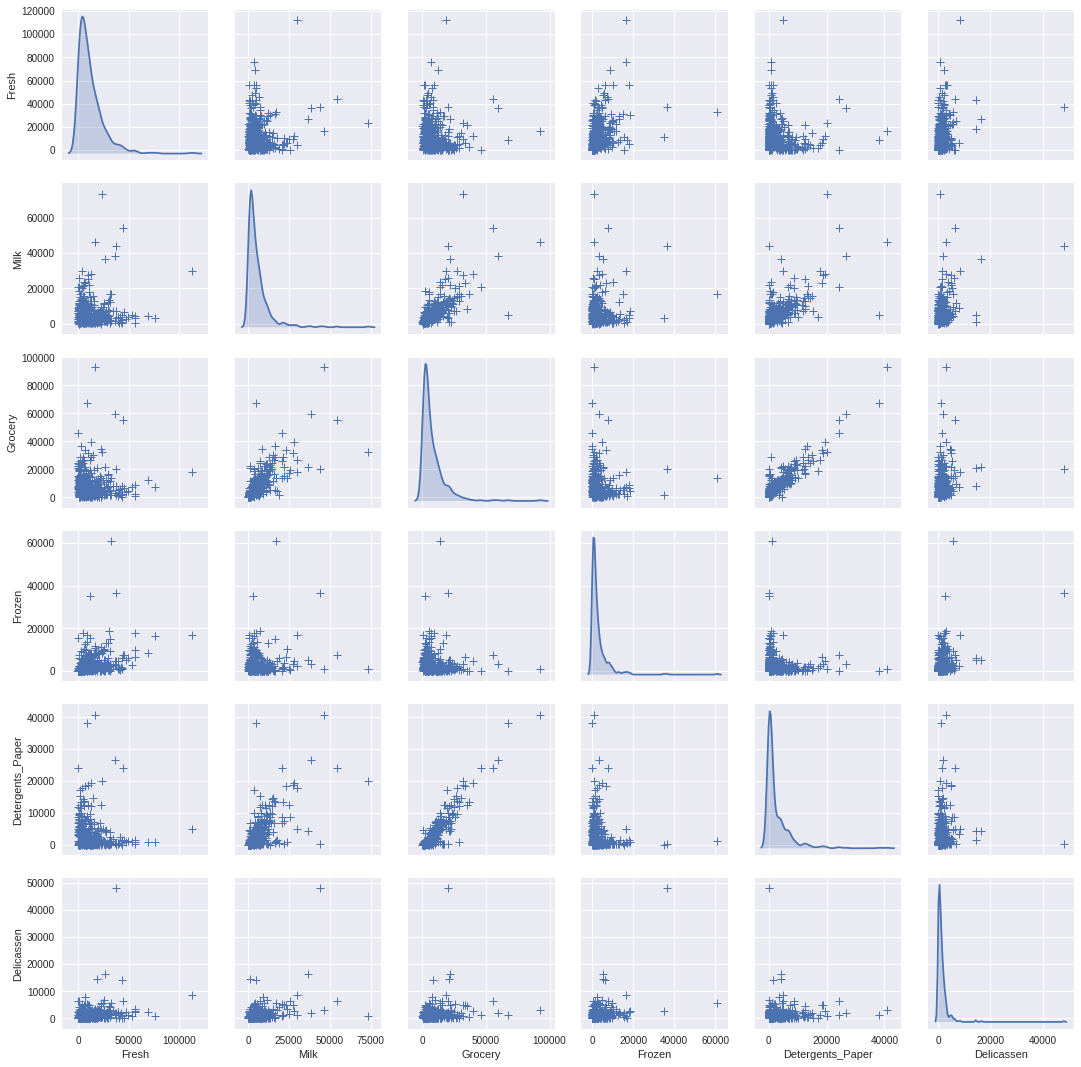

In [9]:
sns.pairplot(data, diag_kind="kde", markers="+",
                     plot_kws=dict(s=50, edgecolor="b", linewidth=1),
                     diag_kws=dict(shade=True))

分布は偏っており、大半の顧客は相対的に少ない支出ですが、かなり多く支出している顧客も少数いることが分かります。  
また、多くの特徴量同士は無相関です。ただし、相関関係も一部に見られます。

## Feature Scaling

このあとはPCA（Feature Extraction）を行いますが、そのためにはFeature Scalingの作業が必要です

In [0]:
#dataに対して適切なFeature Scalingを行うコードを記述

data_fs = np.log(data)

### なぜFeature Scalingが必要なのか

Feature Scalingは意味が広いため今回の例でなぜ必要だったかを説明します。  
では、その理由を説明するために、まずもう一度、散布図行列を出力します。

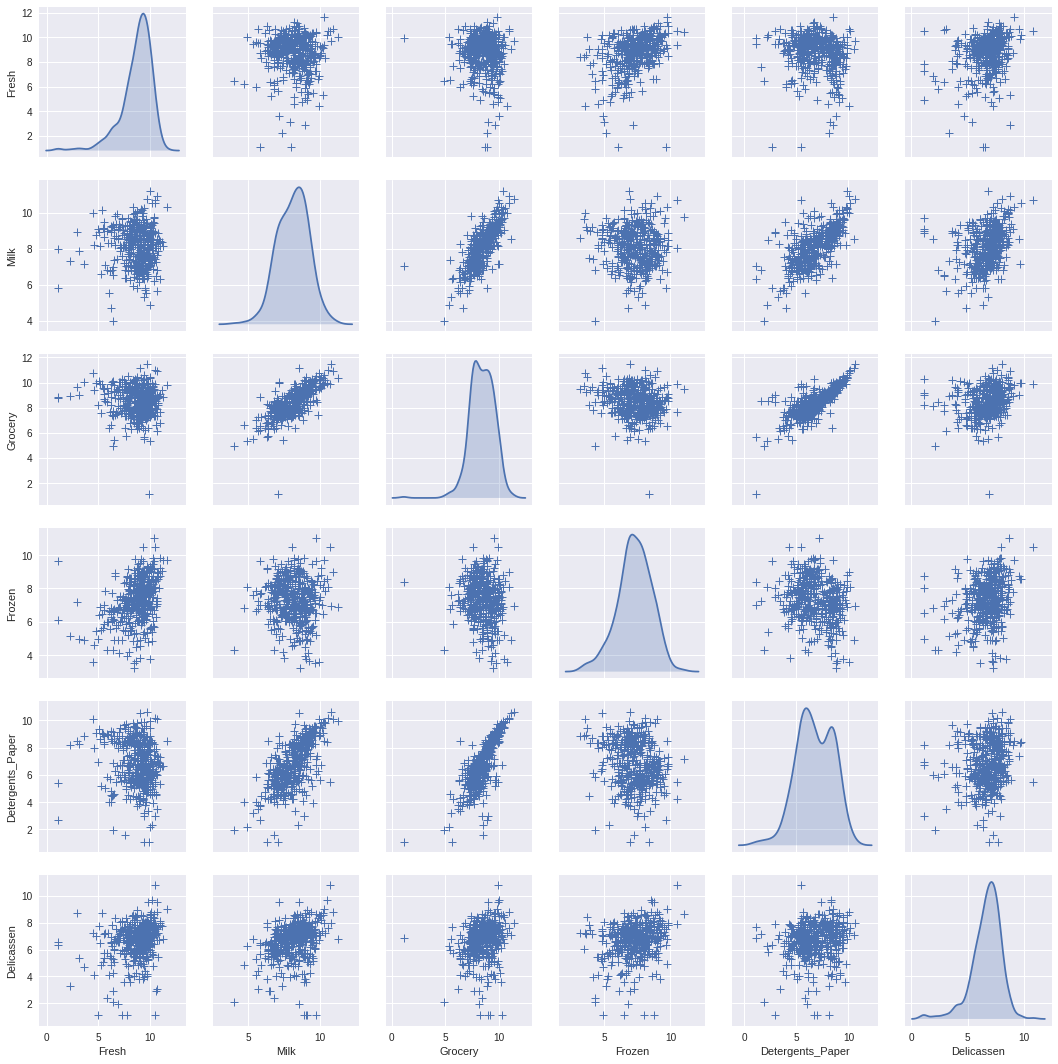

In [11]:
sns.pairplot(data_fs, diag_kind="kde", markers="+",
                     plot_kws=dict(s=50, edgecolor="b", linewidth=1),
                     diag_kws=dict(shade=True))

先ほどのグラフと比較すると、データの分布が真ん中に集まってきていることがわかります。  
これが何を意味しているかというのを一言で言いますと、  
データを分布をよりよく再現する形になった。ということです。  

なぜそのようなことをしたかったかというと、  
テストデータと訓練データが同じ分布から出ているのであれば、  
訓練データに対して高い確率を与えるモデルは、  
テストデータに対しても高い確率を与えるはずと言えるからです。  

より詳しく言いますと、尤度を高くしています  
尤度とは、「条件Hのもとでの確率」で表します。そこで、この確率を尤度(ゆうど)と呼びます。
この問題は突き詰めると最尤推定の手法に繋がります
最尤推定 (maximum likelihood estimation; MLE)とは，この尤度を最大にする，  
すなわち，訓練サンプル集合が生じる確率を最大にするパラメータ値を，パラメータの推定量とする方法のことです。  

また、「分布が見やすく散らばった」ということは、改めてどこに分布が集中しているかを見れることが言えます。  
先ほどの散布図ではどの値に分布が集中しているかの情報が少なかったと言えます。  
こうすることで、クラスタリングがしやすくなります。

間違ってたらコメントいただきたいところです。

## Feature Extraction

### PCAの実行

PCAを行いましょう。  
分散説明率の累積が70%を超える数の主成分を選びます。  

In [12]:
#data_fsに対しPCAを行い分散説明率の累積を確認

from sklearn.decomposition import PCA


# 主成分分析する
pca = PCA(n_components=2)
pca.fit(data_fs)

# 分析結果を元にデータセットを主成分に変換する
data_pca = pca.fit_transform(data_fs)

# 主成分の寄与率を出力する
print('各次元の寄与率: {0}'.format(pca.explained_variance_ratio_))


各次元の寄与率: [0.44237417 0.27657107]


第2主成分までで累積70%を超えました。

In [13]:
data_pca.shape

(440, 2)

2次元に落とし込めているのが確認できました。

### なぜPCAを行うのか記述せよ

機械学習の前処理として情報の圧縮を行いました。  
これは次元の圧縮とも表現されています。  
主成分分析ができると、データの要約ができます。  
データの要約ができると、データの特徴を判断しやすくなります。  
そのため、データのカテゴリ分けなどにも応用が可能です。  

ユーザーのカテゴライズをしたいと思った時、どのように分析するでしょうか。  
ユーザーの年齢や収入、購買頻度などなど様々な要素がデータとして蓄えられているはずです。  
主成分分析ですと、様々な要素をひとまとめにできるので、例えば「収入が多く購買意欲も高いユーザー」など複数の要素を組み合わせて一つのカテゴリとして扱うことができるようになります。  


## クラスタリング

前処理が終わったので、クラスタリングに移ります。

### クラスタリングとは何か記述せよ  

___
**いつ何に使うのか**  
クラスター（cluster）とは、ひとまとまりの集合体のことを言い、クラスタリングとはデータの全体集合をいくつかの集合体に分類する動作、手法のことを言います。  
データを自然なまとまりに分ける手法です。  

例えば、クレジットカードやポイントカードのユーザー情報には、性別、年齢、住所、カード利用履歴などのデータが蓄積されています。  
これらのデータをクラスタリングすることで、ユーザーをさまざまな属性（性別、年齢など）や嗜好性、消費傾向を基準にしたいくつかのグループ（クラスター）に分類します。  
そうすることで、それぞれのグループが持つ異なるニーズに合わせた内容のDMを配布することができ、カードの利用率の向上を狙うことができます。  
___
**階層的手法と非階層的手法との違い**  
非階層クラスター分析は、異なる性質のものが混ざり合った集団から、互いに似た性質を持つものを集め、クラスターを作る方法の1つですが、階層クラスター分析と異なり、階層的な構造を持たず、あらかじめいくつのクラスターに分けるかを決め、決めた数の塊（排他的部分集合）にサンプルを分割する方法といえます。
階層クラスター分析と違い、サンプル数が大きいビッグデータを分析するときに適しています。ただし、あらかじめいくつのクラスターに分けるかは、分析者が決める必要があり、最適クラスター数を自動的には計算する方法は確立されていません。

階層的手法は凝集型（agglomerative）と、もうひとつ分岐型（divisive）に分けられます。凝集型ではボトムアップ的に階層を作っていきましたが、分岐型はトップダウン的に分割していきます。計算量が少ないために凝集型が使われることが多いです。
___
**クラス分類（classification）との比較**  
どちらも言ってしまえばデータを分ける話ですが、クラス分類は教師あり学習であり、クラスタリングは教師なし学習です。  
クラス分類の場合は事前に分類が用意されていて、そこにデータを正しく入れていく作業です。何にどう分けるのかを人間が与えるので、「教師あり」なのです。一方クラスタリングの場合に分類は用意されておらず、データを見てうまい具合に分けていきます。  

### 樹状図を描く


まずは階層的手法を使い、樹状図を描いてみます。手法はいくつもありましたが、ward法が良いでしょう。

(閾値の設定
appray)

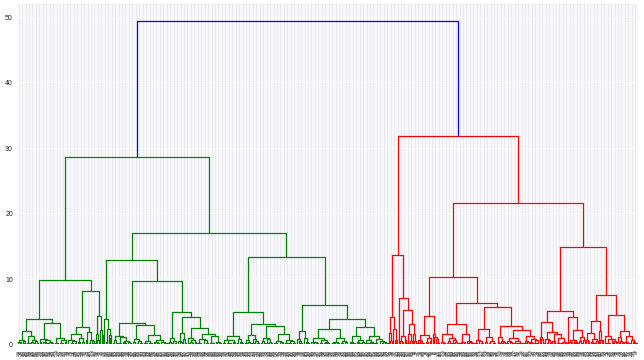

In [14]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# 階層型クラスタリングの実施
# ウォード法 x ユークリッド距離
linkage_result = linkage(data_pca, method='ward', metric='euclidean')

# 階層型クラスタリングの可視化
plt.figure(num=None, figsize=(16, 9), dpi=50, facecolor='w', edgecolor='k')
dendrogram(linkage_result)
plt.show()


ここでは三つに分類されていることがわかります。  
大きく6つでに別れているラインで考えるのも良さそうですね。  
他の手法も用いてその妥当性をチェックしていきたいと思います。

### k-meansにおけるkの値の検討


クラスタリングはk-meansが定石です。まずはクラスタ数kの値を検討します。

まずはそのためにエルボー法と、シルエット法を見て見たいと思います。  
クラス数kを増やしたとしてもSSEがあまり変わらなくなる点を見つけていきます
SSEは言葉で言えば「あるサンプルとクラスタの中心点との距離の合計」です。

#### エルボー法

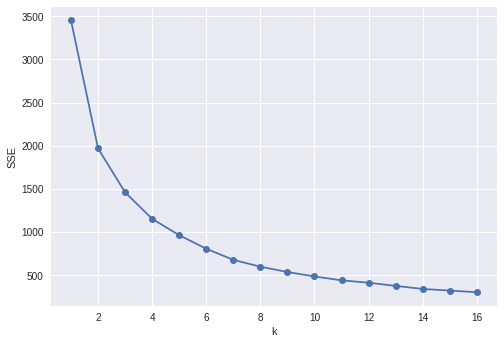

In [15]:
from sklearn.cluster import KMeans

SSE = []
for i in range(1, 17):
    km = KMeans(n_clusters=i, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=111)
    km.fit(data_pca)
    SSE.append(km.inertia_)

plt.plot(range(1,17), SSE, marker='o')
plt.xlabel('k')
plt.ylabel('SSE')
plt.show()

エルボー法では適切なkはおよそ2~7辺りと言えそうですね。  
シルエット法でその辺りを入れてその様子を見て見ましょう

#### シルエット法

各クラスタのサンプルの凝集度（まとまり具合）を表示して、それぞれを比べます。

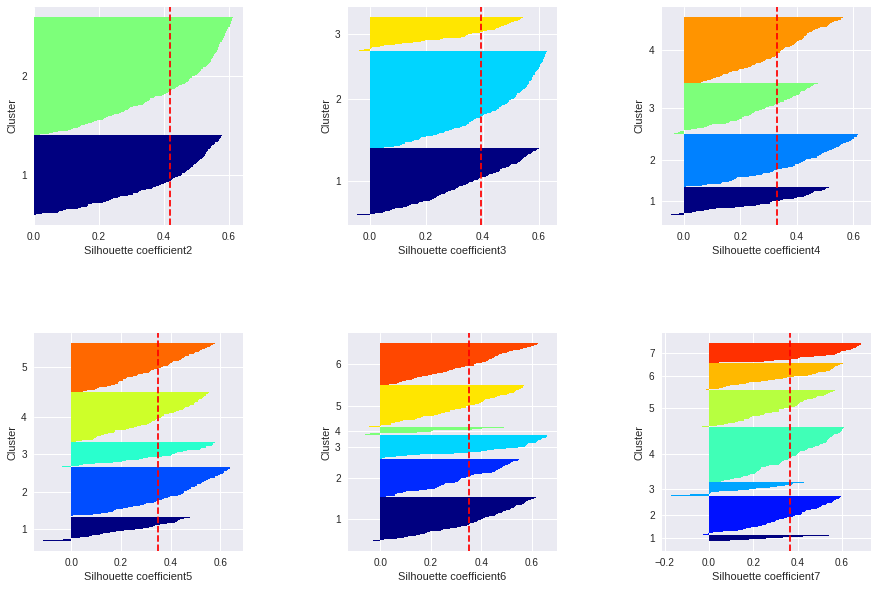

In [16]:
from matplotlib import cm
from sklearn.metrics import silhouette_samples

plt.figure(figsize=(15,10))
plt.subplots_adjust(wspace=0.5,hspace=0.5)

for i in range(2, 8):
  plt.subplot(2,3,i - 1)
  km = KMeans(n_clusters=i, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=111)
  y_km = km.fit_predict(data_pca)

  cluster_labels = np.unique(y_km) # y_kmの要素の中で重複を無くす
  n_clusters = cluster_labels.shape[0] # 配列の長さを返す。
  
  # シルエット係数を計算
  silhouette_vals = silhouette_samples(data_pca, y_km, metric='euclidean')# サンプルデータ, クラスター番号、ユークリッド距離でシルエット係数計算
  y_ax_lower, y_ax_upper = 0, 0
  yticks = []
  for i, c in enumerate(cluster_labels):
      c_silhouette_vals = silhouette_vals[y_km == c]
      c_silhouette_vals.sort()
      y_ax_upper += len(c_silhouette_vals)
      color = cm.jet(i / n_clusters)
      plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
      yticks.append((y_ax_lower + y_ax_upper) / 2)
      y_ax_lower += len(c_silhouette_vals)

  silhouette_avg = np.mean(silhouette_vals)
  plt.axvline(silhouette_avg, color="red", linestyle="--")
  plt.yticks(yticks, cluster_labels + 1)
  plt.ylabel('Cluster')
  plt.xlabel('Silhouette coefficient{}'.format(i+1))
  
plt.show()

[シルエット法のコード](https://qiita.com/deaikei/items/11a10fde5bb47a2cf2c2)   

ここで、2の分割をみると最もバランスが良く分割できているのがわかりました。  
それぞれの棒（サンプル数）が均一にばらけており、  
かつ平均線を超えていることから、良い分割ということが言えます。

結論としては、k=2の値を採用したいと思います。

### k-meansの実行

In [0]:
# K-Meansのクラスタ分析クラス初期化
k_model = KMeans(n_clusters=2, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=111)
# ベクトル情報を食わせて、クラスタ分析を実行
y_km = k_model.fit_predict(data_pca)

### クラスタリングの可視化

PCAにより特徴量は可視化可能な次元に落ちているはずです。可視化することで分かってくることもあります。  
散布図を描き、クラスタ毎に色分けしましょう。中心点（セントロイド）もプロットしてみます。  

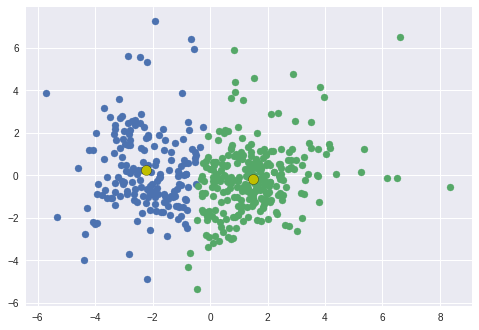

In [18]:
#散布図を描くコードを記述

# 各要素をラベルごとに色付けして表示する
for i in range(2):
    labels = data_pca[y_km == i]
    plt.scatter(labels[:, 0], labels[:, 1])

# クラスタのセントロイド (重心) を描く
centers = k_model.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], s=100, facecolors='y', edgecolors='black')

## クラスタを見る


### 既知のグループとの比較

Channel、Regionで色分けをして比較してみましょう。

In [0]:
channel = data_original.Channel
region = data_original.Region

regionで色分けして見ましょう

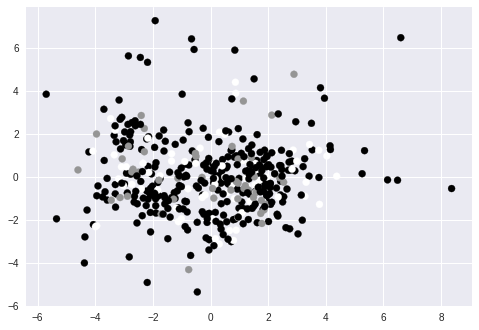

In [20]:
plt.scatter(data_pca[:,0], data_pca[:,1], c=region)

うまく分類ができていません。  
次はChannelで分類して見ましょう

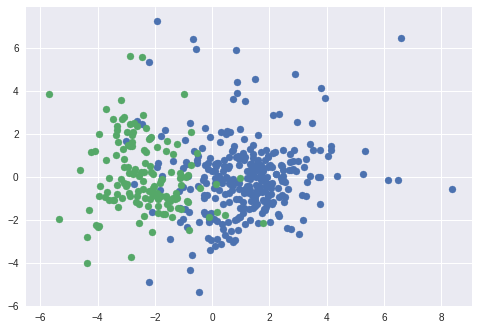

In [21]:
for i in range(1,3):
    labels = data_pca[channel == i]
    plt.scatter(labels[:, 0], labels[:, 1])

Channelの2分類は主成分分析したデータをうまく分けられています。  

k-meansでクラスタリングしたデータと近いことがわかります。  

## 卸売業者への報告

まずイメージとして、Channelの場合分けで攻めるのがよさそうです。  
なので、Channelのホテルか小売店でどのように  
商品の売り上げに差があるのかの統計を見ていきます。


In [0]:
Horeca = data_original[data_original["Channel"] == 1].describe().drop(['Channel', 'Region'], axis=1).loc['mean']
Retail = data_original[data_original["Channel"] == 2].describe().drop(['Channel', 'Region'], axis=1).loc['mean']

____
ホテルの場合の売り上げ

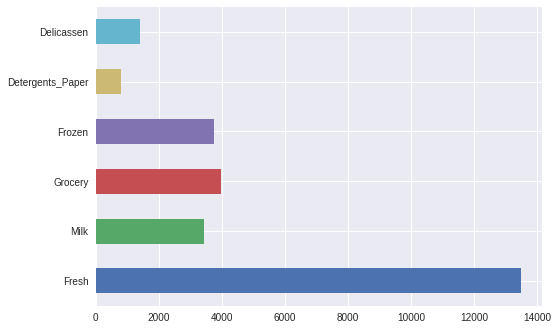

In [23]:
Horeca.plot.barh()

___
小売店の場合の売り上げ

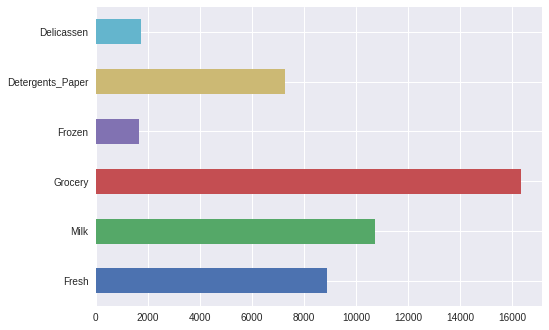

In [24]:
Retail.plot.barh()

___
それぞれの差のプロットです。  
左に多いものがHorecaの値です。  
右に多いものがRetailの値です。

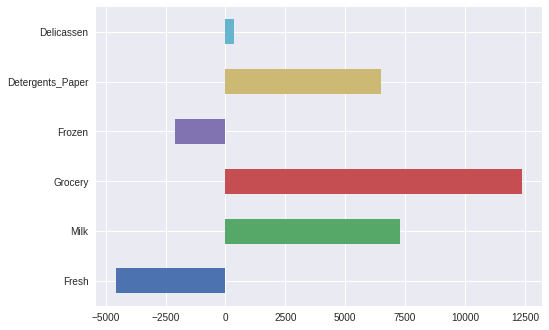

In [25]:
(Retail - Horeca).plot.barh()

今回の分析で地域ごとの売り上げの差はあまり関係がないということがわかりました。  
注目するべきはChannelだと考えられます。  

まず地域による差がないというのは、地域によって商品ごとの売り上げを表現することができていないことから言えます。それは上記のグラフから判断することが可能です。  
一方、Channelでは、そのグラフがデータを良く分類しており、Channelによって売れているものの金額が異なっていることが言えます。
棒グラフでその差を視覚的にみることができます。  

具体的なアドバイスですと、  
ホテルでは冷凍食品、生鮮食品を特に販売し  
小売店ではミルク、食料品、紙製品を販売し売り上げを大きくすることができると思います。

## オプション。  
k-meansスクラッチ

In [0]:
from sklearn import datasets

# クラスタ数
n_cluster = 6

# Blob データを生成する
dataset = datasets.make_blobs(centers=n_cluster)

# 特徴データ
x = dataset[0]
# 正解ラベルは使わない
# targets = dataset[1]

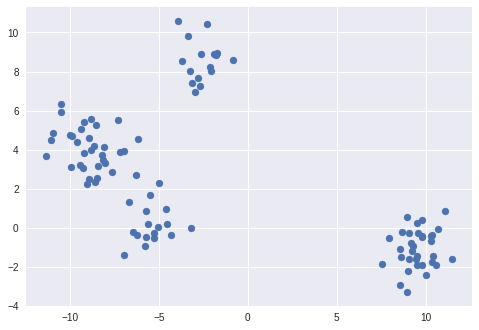

In [27]:
plt.scatter(x[:, 0], x[:, 1])

これをクラスタリングしていく

In [0]:
# k個の中心点をランダムに選ぶ
def make_center(x, n_cluster):  
  import random
  
  center = []

  for k in range(n_cluster):
    center_x = random.randrange(round(np.min(x[:, 0])), round(np.max(x[:, 0])))
    center_y = random.randrange(round(np.min(x[:, 1])), round(np.max(x[:, 1])))
    center_new = [center_x, center_y]
    center += [center_new]
  
  return center

In [29]:
make_center(x, n_cluster)

[[-2, 8], [4, 5], [7, -1], [6, -2], [0, -2], [-11, -1]]

In [30]:
cluster_group =  [[] for i in range(n_cluster)]
cluster_group

[[], [], [], [], [], []]

In [31]:
#各サンプルを最も近い中心点に割り当てクラスタを作る。

center = make_center(x, n_cluster)
cluster_group =  [[] for i in range(n_cluster)]

for i in x:
  norms = []
  
  for j in center:
    norms += [np.linalg.norm( i - j )]
  
  min_index = np.argmin(norms)
  cluster_group[min_index] += [i]
  
cluster_group

[[array([ 8.97394772, -3.29265713]),
  array([ 8.54012976, -2.94054181]),
  array([ 9.02146864, -2.225608  ]),
  array([ 7.56329795, -1.83513234])],
 [array([-4.9754556 ,  2.28035099]),
  array([-8.05678889,  4.14874801]),
  array([-5.74218167,  0.87656083]),
  array([-5.28494222, -0.2666042 ]),
  array([-7.16293545,  3.90073414]),
  array([-8.20068007,  3.7044802 ]),
  array([-6.2000212, -0.3598167]),
  array([-6.18158379,  4.54447645]),
  array([-8.15389263,  3.44338174]),
  array([-8.89857689,  2.51942297]),
  array([-9.97405531,  4.73967469]),
  array([-8.64057005,  4.16519148]),
  array([-8.00714561,  3.29689732]),
  array([-9.87143133,  4.70773738]),
  array([-4.54810192,  0.19260099]),
  array([-5.47590677,  1.67953339]),
  array([-5.70903791, -0.46006058]),
  array([-9.2653058 ,  3.04361265]),
  array([-6.93759085,  3.92290281]),
  array([-9.03169503,  2.25863609]),
  array([-11.03838224,   4.49836986]),
  array([-9.20869459,  3.85010727]),
  array([-5.2815015 , -0.53199466]),


[0, -3]
[-7, 1]
[8, 9]
[5, 6]
[-7, -3]
[-5, 8]


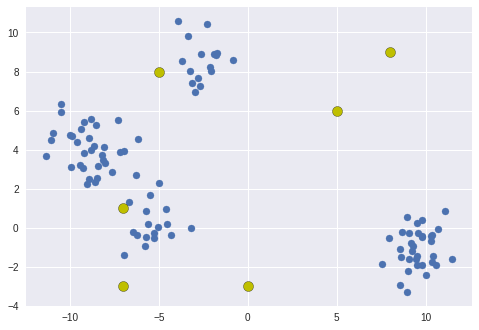

In [32]:
# この段階でのプロットをしてみる
plt.scatter(x[:, 0], x[:, 1])

for j in center:
  print(j)
  plt.scatter(j[0], j[1], s=100, facecolors='y', edgecolors='black')

In [33]:
# クラスタの実際の中心(平均)を計算し、そこを新たな中心点とする。
center_new = []

for i in range(n_cluster):
  center_new += [np.mean(cluster_group[i], axis = 0)]
center_new

[array([ 8.52471102, -2.57348482]),
 array([-7.53039862,  2.446496  ]),
 nan,
 array([ 9.68798513, -0.8538956 ]),
 array([-6.9633643 , -1.37893718]),
 array([-4.36205759,  7.78424489])]

ここまでの処理をまとめてループさせる

In [0]:
# 2~3を繰り返す。設定した回数分繰り返させる。


center = make_center(x, n_cluster)
cluster_group =  [[] for i in range(n_cluster)]
ite = 100

for n in range(ite):
  
  #各サンプルを最も近い中心点に割り当てクラスタを作る。
  for i in x:
    norms = []

    for j in center:
      norms += [np.linalg.norm( i - j )]

    min_index = np.argmin(norms)
    cluster_group[min_index] += [i]

  # クラスタの実際の中心(平均)を計算し、そこを新たな中心点とする。
  center_new = []

  for i in range(n_cluster):
    center_new += [np.mean(cluster_group[i], axis = 0)]
  center = center_new

[-1.21216957  2.40040385]
[ 9.54698221 -1.06233065]
[-8.9081067  4.0551246]
[-1.19215757  2.42463363]
[-5.45184397  0.30067415]
[-2.57284547  8.57383223]


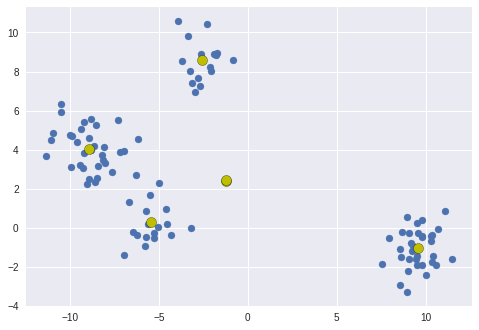

In [35]:
# この段階でのプロットをしてみる
plt.scatter(x[:, 0], x[:, 1])

for j in center:
  print(j)
  plt.scatter(j[0], j[1], s=100, facecolors='y', edgecolors='black')

だいぶ近づいている(感動)(歓喜)  

これを回数で決めるのではなく、中心点がほとんど動かなくなったら  
終了にさせる。

In [0]:
# 2~3を繰り返す。設定した距離まで許容する。


center = make_center(x, n_cluster)
cluster_group =  [[] for i in range(n_cluster)]
tol = 10000
stop = 10

while tol > stop:
  
  #各サンプルを最も近い中心点に割り当てクラスタを作る。
  for i in x:
    norms = []

    for j in center:
      norms += [np.linalg.norm( i - j )]
      tol = np.max(np.linalg.norm( i - j ))
    min_index = np.argmin(norms)
    cluster_group[min_index] += [i]
    


  # クラスタの実際の中心(平均)を計算し、そこを新たな中心点とする。
  center_new = []

  for i in range(n_cluster):
    center_new += [np.mean(cluster_group[i], axis = 0)]
  center = center_new

[9.18623594 8.2955807 ]
[1.01671294 2.7497042 ]
[ 3.2823925  -1.27452242]
[-6.38357872 -8.04770742]
[-8.38759009  0.66818647]
[-1.16686588 -3.83309386]


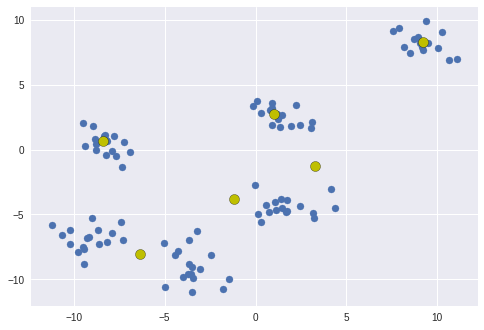

In [56]:
# プロットをしてみる
plt.scatter(x[:, 0], x[:, 1])

for j in center:
  print(j)
  plt.scatter(j[0], j[1], s=100, facecolors='y', edgecolors='black')

距離はまだまだデータに左右されるところがあり、  
理解しきれていないところがあるようですが、  
ひとまずクラスタリングができたところで終了いたします。